# NLP (Natural Language Processing) Workflow

1. Exploratory Data Analysis (Frequency Distribution | Parse Trees)
2. Text Preprocessing (Tokenize, Stem, Lemmatize, Vectorize)
3. Feature Engineering (Bigrams, POS-Tags, TF-IDF)
4. Modeling
5. Model Evaluation

## EDA (Exploratory Data Analysis)

"Exploratory Data Analysis is the process of exploring data, generating insights, testing hypotheses, checking assumptions and revealing underlying hidden patterns in the data".

Through these we can get a basic description of the data, visualize it, identify pattern in it, identify potential challenges of using the data, etc.

The dataset (zip file) can be downloaded from this URL -- https://archive.ics.uci.edu/ml/machine-learning-databases/00228/. 

In [2]:
#import pandas
import pandas as pd

In [3]:
sms = pd.read_table('./SMSSpamCollection', header=None)

In [5]:
# see the top 5 records
sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Describe the data

To begin, we can use the describe() function to obtain various summary statistics that exclude NaN values.

In [6]:
sms.describe()

,0,1
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Data Info

Here, we have a collection of text data known as a corpus. Specifically, there are 5,572 SMS messages written in English, serving as training examples. The first column is the target variable containing the class labels, which tells us if the message is spam or ham (aka not spam). The second column is the SMS message itself, stored as a string.

Since the target variable contains discrete values, this is a **classification** task. Let's start by placing the target variable in its own table and checking out how the two classes are distributed.

In [7]:
y = sms[0]
y.value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

It looks like there are far fewer training examples for spam than ham—we'll take this imbalance into account in the analysis.

In addition, we need to encode the class labels in the target variable as numbers to ensure compatibility with some models in Scikit-learn. Because we have binary classes, let's use LabelEncoder and set 'spam' = 1 and 'ham' = 0.

LabelEncoder is a function of scikit learn's preprocessing capabilities, which helps to encode target labels with values between 0 and the (# of classes) - 1. 

In [8]:
from sklearn import preprocessing

In [9]:
le = preprocessing.LabelEncoder()
y_enc = le.fit_transform(y)

In [10]:
y_enc

array([0, 0, 1, ..., 0, 0, 0])

Next, we place the SMS message data into its own table. We must convert this corpus into useful numerical features so we can train this classifier and this is where NLP works its magic!

In [11]:
raw_text = sms[1]

In [12]:
raw_text

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: 1, Length: 5572, dtype: object

Another important part of any dataset is missing values. When this happens, the dataset can lose expressiveness, which may lead to weak or at times biased analyses. Practically, this means that when you’re missing values for certain features, the chances of your classification or predictions for the data being off only increase.

To identify the rows that contain missing values, you can use isnull(). In the result that you’ll get back, you’ll see True or False appearing in each cell: True will indicate that the value contained within the cell is a missing value, False means that the cell contains a ‘normal’ value.

In [13]:
pd.isnull(sms)

,0,1
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
5567,False,False
5568,False,False
5569,False,False
5570,False,False


In this case, you see that the data is quite complete: there are no missing values and you're lucky! But this is definitely not always the case for datasets out there.

### Basic Visualization

Data visualization can help with identifying patterns in the data. The Python libraries Seaborn and Matplotlib are easy and quick ways to do this. 

In [14]:
import matplotlib as plt
import seaborn as sns

There are a couple basic visualizations we can do. The first is displaying the length of all the dataset instances. To do this, we must first label the columns with their appropriate titles and add a column to the dataset that contains the length. 

In [15]:
sms.columns=['label', 'msg']

In [16]:
sms.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
sms["length"] = sms["msg"].apply(len)

In [18]:
sms.head()

,label,msg,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


C:\Users\chara\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length'>

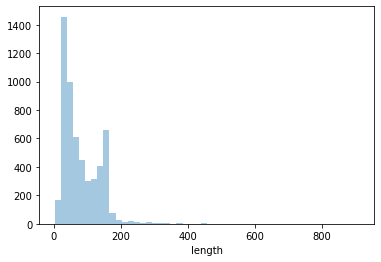

In [19]:
sns.distplot(sms["length"], kde=False)

## Pre-Processing

There are many feature engineering strategies for transforming text data into features. NLP problem requires a tailored approach to determine which terms are relevant and meaningful, and this is where we begin our pre-processing.

### Step 1: Contraction Mapping / Expanding Contractions

Contractions are words that we write with an apostrophe. Examples of contractions are words like “ain’t” or “aren’t”. Since we want to standardize our text, it makes sense to expand these contractions. We are going to add a new column to our dataframe called “no_contract” and apply a lambda function to the "msg" field which will expand any contractions.

In [20]:
!pip install contractions
import contractions

You should consider upgrading via the 'C:\Users\chara\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [21]:
sms['no_contract'] = sms['msg'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [22]:
sms.head()

,label,msg,length,no_contract
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he..."


In [23]:
sms["msg_str"] = [' '.join(map(str, l)) for l in sms['no_contract']]

In [24]:
sms.head()

,label,msg,length,no_contract,msg_str
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar..."


### Step 2: Tokenization


In this step, we construct the features. We will begin by breaking apart the corpus into a vocabulary of unique terms, and this is called tokanization. 

We can tokenize individual terms and generate what's called a bag of words model. We can also tokenize using nltk, which is the leading platform for building Python programs to work with human language data. 

In [25]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Now, we can apply the tokenizer to our dataset. We will apply NLTK.word_tokenize() function to the “msg_str” column and create a new column named “tokenized”.

In [26]:
sms['tokenized'] = sms['msg_str'].apply(word_tokenize)
sms.head()

,label,msg,length,no_contract,msg_str,tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,..."


### Step 3: Noise Cleaning - spacing, special characters, lowercasing


Let'a take a small step back and examine a few random examples of SMS messages from our dataset. 

In [27]:
sms.sample(frac=0.05)

,label,msg,length,no_contract,msg_str,tokenized
2971,ham,U should make a fb list,23,"[YOU, should, make, a, fb, list]",YOU should make a fb list,"[YOU, should, make, a, fb, list]"
3092,spam,LORD OF THE RINGS:RETURN OF THE KING in store ...,140,"[LORD, OF, THE, RINGS:RETURN, OF, THE, KING, i...",LORD OF THE RINGS:RETURN OF THE KING in store ...,"[LORD, OF, THE, RINGS, :, RETURN, OF, THE, KIN..."
1927,ham,Dont give a monkeys wot they think and i certa...,135,"[Do Not, give, a, monkeys, wot, they, think, a...",Do Not give a monkeys wot they think and i cer...,"[Do, Not, give, a, monkeys, wot, they, think, ..."
3714,ham,If i not meeting ü all rite then i'll go home ...,84,"[If, i, not, meeting, ü, all, rite, then, i wi...",If i not meeting ü all rite then i will go hom...,"[If, i, not, meeting, ü, all, rite, then, i, w..."
5476,ham,Yes princess! I want to please you every night...,74,"[Yes, princess!, I, want, to, please, you, eve...",Yes princess! I want to please you every night...,"[Yes, princess, !, I, want, to, please, you, e..."
...,...,...,...,...,...,...
129,ham,HEY GIRL. HOW R U? HOPE U R WELL ME AN DEL R B...,107,"[HEY, GIRL., HOW, R, YOU?, HOPE, YOU, R, WELL,...",HEY GIRL. HOW R YOU? HOPE YOU R WELL ME AN DEL...,"[HEY, GIRL, ., HOW, R, YOU, ?, HOPE, YOU, R, W..."
449,ham,LOL ... Have you made plans for new years?,42,"[LOL, ..., Have, you, made, plans, for, new, y...",LOL ... Have you made plans for new years?,"[LOL, ..., Have, you, made, plans, for, new, y..."
5193,ham,"It's wylie, you in tampa or sarasota?",37,"[It is, wylie,, you, in, tampa, or, sarasota?]","It is wylie, you in tampa or sarasota?","[It, is, wylie, ,, you, in, tampa, or, sarasot..."
1799,ham,That one week leave i put know that time. Why.,46,"[That, one, week, leave, i, put, know, that, t...",That one week leave i put know that time. Why.,"[That, one, week, leave, i, put, know, that, t..."


Transforming all words to lowercase is also a very common pre-processing step. In this case, we will once again append a new column named “lower” to the dataframe which will transform all the tokenized words into lowercase.

In [30]:
sms['lower'] = sms['tokenized'].apply(lambda x: [word.lower() for word in x])
sms.head()

,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he..."


Next, we'll remove all punctuation since they serve little value once we begin to analyze our data.

In [31]:
import string
punc = string.punctuation
sms['no_punc'] = sms['lower'].apply(lambda x: [word for word in x if word not in punc])
sms.head()

,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he..."


### Step 4: ‘Stop Words’ Identification

Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out.

First, we need to import the NLTK stopwords library and set our stopwords to “english”. 

In [35]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed. Once again a for-loop within a lambda function will iterate over the tokens in “no_punc” and only return the tokens which do not exist in our “stop_words” variable.

In [36]:
sms['stopwords_removed'] = sms['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
sms.head()

,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc,stopwords_removed
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, jurong, point, crazy, .., available, bugi..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[dun, say, early, hor, ..., c, already, say, ...]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he...","[nah, think, goes, usf, lives, around, though]"


### Step 5: Stemming/Lemmatization

The idea of stemming is to reduce different forms of word usage into its root word. For example, “drive”, “drove”, “driving”, “driven”, “driver” are derivatives of the word “drive” and very often researchers want to remove this variability from their corpus. Compared to lemmatization, stemming is certainly the less complicated method but it often does not produce a dictionary-specific morphological root of the word. In other words, stemming the word “pies” will often produce a root of “pi” whereas lemmatization will find the morphological root of “pie”.

Instead of taking the easy way out with stemming, let’s apply lemmatization to our data but it requires some additional steps compared to stemming. First, we have to apply parts of speech tags, in other words, determine the part of speech (ie. noun, verb, adverb, etc.) for each word.

In [37]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [38]:
sms['pos_tags'] = sms['stopwords_removed'].apply(nltk.tag.pos_tag)
sms.head()

,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, jurong, point, crazy, .., available, bugi...","[(go, VB), (jurong, JJ), (point, NN), (crazy, ..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, oni, ...]","[(ok, JJ), (lar, NN), (..., :), (joking, VBG),..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[(free, JJ), (entry, NN), (2, CD), (wkly, JJ),..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[dun, say, early, hor, ..., c, already, say, ...]","[(dun, NNS), (say, VBP), (early, JJ), (hor, NN..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he...","[nah, think, goes, usf, lives, around, though]","[(nah, RB), (think, NN), (goes, VBZ), (usf, JJ..."


We are going to be using NLTK’s word lemmatizer which needs the parts of speech tags to be converted to wordnet’s format.

In [39]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [40]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [42]:
nltk.download('omw-1.4')
sms['wordnet_pos'] = sms['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
sms.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, jurong, point, crazy, .., available, bugi...","[(go, VB), (jurong, JJ), (point, NN), (crazy, ...","[(go, v), (jurong, a), (point, n), (crazy, n),..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, oni, ...]","[(ok, JJ), (lar, NN), (..., :), (joking, VBG),...","[(ok, a), (lar, n), (..., n), (joking, v), (wi..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[(free, JJ), (entry, NN), (2, CD), (wkly, JJ),...","[(free, a), (entry, n), (2, n), (wkly, a), (co..."
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[dun, say, early, hor, ..., c, already, say, ...]","[(dun, NNS), (say, VBP), (early, JJ), (hor, NN...","[(dun, n), (say, v), (early, a), (hor, n), (....."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he...","[nah, think, goes, usf, lives, around, though]","[(nah, RB), (think, NN), (goes, VBZ), (usf, JJ...","[(nah, r), (think, n), (goes, v), (usf, a), (l..."


Now we can apply NLTK’s word lemmatizer within our trusty list comprehension. Notice, the lemmatizer function requires two parameters the word and its tag (in wordnet form).

In [44]:
from nltk.stem import WordNetLemmatizer

In [57]:
wnl = WordNetLemmatizer()
sms['lemmatized'] = sms['wordnet_pos'].apply(lambda x: " ".join([wnl.lemmatize(word, tag) for word, tag in x]))
sms.head()

,label,msg,length,no_contract,msg_str,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point,, crazy.., Available...","Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, jurong, point, crazy, .., available, bugi...","[(go, VB), (jurong, JJ), (point, NN), (crazy, ...","[(go, v), (jurong, a), (point, n), (crazy, n),...",go jurong point crazy .. available bugis n gre...
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar..., Joking, wif, you, oni...]",Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joking, wif, oni, ...]","[(ok, JJ), (lar, NN), (..., :), (joking, VBG),...","[(ok, a), (lar, n), (..., n), (joking, v), (wi...",ok lar ... joke wif oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[(free, JJ), (entry, NN), (2, CD), (wkly, JJ),...","[(free, a), (entry, n), (2, n), (wkly, a), (co...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,"[YOU, dun, say, so, early, hor..., YOU, c, alr...",YOU dun say so early hor... YOU c already then...,"[YOU, dun, say, so, early, hor, ..., YOU, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[you, dun, say, so, early, hor, ..., you, c, a...","[dun, say, early, hor, ..., c, already, say, ...]","[(dun, NNS), (say, VBP), (early, JJ), (hor, NN...","[(dun, n), (say, v), (early, a), (hor, n), (.....",dun say early hor ... c already say ...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do not, think, he, goes, to, usf,, he...","Nah I do not think he goes to usf, he lives ar...","[Nah, I, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, ,,...","[nah, i, do, not, think, he, goes, to, usf, he...","[nah, think, goes, usf, lives, around, though]","[(nah, RB), (think, NN), (goes, VBZ), (usf, JJ...","[(nah, r), (think, n), (goes, v), (usf, a), (l...",nah think go usf life around though


Lastly, we should save all of our pre-processing work for the next steps in the workflow. We can simnple save it as a csv file.

In [58]:
sms.to_csv('sms_spam_collection.csv')

# Modeling

We will use the TF-IDF Vertorizer to convert the raw documents into feature matrix which is very important to train a Machine Learning model:

In [ ]:
from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y = sms.label.values
x=tfidf.fit_transform(sms.lemmatized)

# Training Machine Learning Model
Now to train a machine learning model I will split the data into 50 percent training and 50 percent test sets:

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.5,shuffle=False)

Now let’s train a machine learning model for the task of sentiment analysis by using the Logistic Regression model:

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf=LogisticRegressionCV(cv=6,scoring='accuracy',random_state=0,n_jobs=-1,verbose=3,max_iter=500).fit(X_train,y_train)
y_pred = clf.predict(X_test)
from sklearn import metrics

# Model Evaluation

In [64]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   15.5s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.6s finished


Accuracy: 0.9723618090452262




---



---

